In [94]:
import os

import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.interpolate import UnivariateSpline

from src.data import raw_io as io
from src.data import conditions as cond

In [2]:
np.random.seed(42)

In [3]:
DATA_PATH = os.path.join('..', 'data', 'processed', 'trials_by_celltype')

In [4]:
def load_sessions_by_day(day: cond.Day):
    sessions = {}
    with h5py.File(os.path.join(DATA_PATH, str(day) + '.h5'), 'r') as f:
        for cell_type in cond.CellType:
            sessions[cell_type] = []
            for mouse in f[cell_type.as_path()].keys():
                sessions[cell_type].append(
                    io.SessionTrials.load(f[cell_type.as_path()][mouse])
                )

        f.close()
    
    return sessions

In [5]:
raw_data_by_day = {
    cond.DAYS[0]: load_sessions_by_day(cond.DAYS[0]), 
    cond.DAYS[-1]: load_sessions_by_day(cond.DAYS[-1])
}

In [6]:
def get_mean_fluorescence_by_cell_type(daily_data):
    mean_fluorescence = {}
    for cell_type in daily_data.keys():

        # Concatenate fluorescence of each mouse
        mean_fluorescence[cell_type] = daily_data[cell_type][0].fluo.trial_mean()
        for i in range(1, len(daily_data[cell_type])):
            trial_mean_fluo = daily_data[cell_type][i].fluo.trial_mean()
            mean_fluorescence[cell_type].append(
                trial_mean_fluo
            )
            del trial_mean_fluo

        print('Got {} {} cells'.format(mean_fluorescence[cell_type].fluo.shape[0], cell_type))
        mean_fluorescence[cell_type].remove_nan()
    
    return mean_fluorescence

In [7]:
mean_fluorescence_by_day = {
    day: get_mean_fluorescence_by_cell_type(raw_data_by_day[day]) 
    for day in raw_data_by_day.keys()
}

Got 1209 pyr cells
Got 189 som cells
Got 252 pv cells
Got 407 vip cells
Got 2098 pyr cells
Got 318 som cells
Got 362 pv cells
Got 565 vip cells


/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:714: UserWarning: Removing 2 all-nan rows
  warnings.warn('Removing {} all-nan rows'.format(np.sum(all_nan_rows)))
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:660: ShapeWarning: `num_frames` in self (428) and other (435) do not match, 7 excess frames will be trimmed from the end of other
  warnings.warn(
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:714: UserWarning: Removing 4 all-nan rows
  warnings.warn('Removing {} all-nan rows'.format(np.sum(all_nan_rows)))
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:714: UserWarning: Removing 7 all-nan rows
  warnings.warn('Removing {} all-nan rows'.format(np.sum(all_nan_rows)))
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:660: ShapeWarning: `num_frames` in self (428) and other (438) do not match, 10 excess frames will be trimmed from the end of other
  warnings.warn(
/Users/eharkin/Documents/projects/candice/src/data/raw_

# Aggregate fluorescence 

In [8]:
labels = []
fluo_matrices = []
for cell_type in cond.CellType:
    labels.extend(
        [
            str(cell_type) for i in 
            range(mean_fluorescence_by_day[cond.DAYS[-1]][cell_type].fluo.shape[0])
        ]
    )
    fluo_matrices.append(mean_fluorescence_by_day[cond.DAYS[-1]][cell_type].fluo)
    
min_num_frames = np.min([fl.shape[1] for fl in fluo_matrices])

grand_fluo = io.LongFluorescence(
    0, 
    [i for i in range(len(labels))], 
    np.concatenate([fl[:, :min_num_frames] for fl in fluo_matrices])
)
grand_fluo.cell_type = labels

del fluo_matrices, min_num_frames, labels

In [9]:
pca = PCA(random_state=42)
transformed = pca.fit_transform(grand_fluo.fluo)

Text(0.5, 0, 'Component no.')

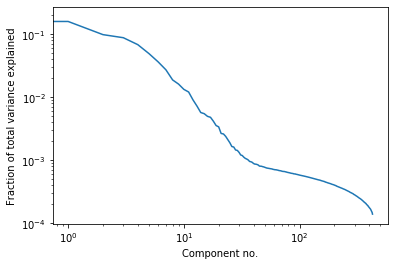

In [10]:
plt.loglog(pca.explained_variance_ratio_)
plt.ylabel('Fraction of total variance explained')
plt.xlabel('Component no.')

Text(0.5, 0, 'Component no.')

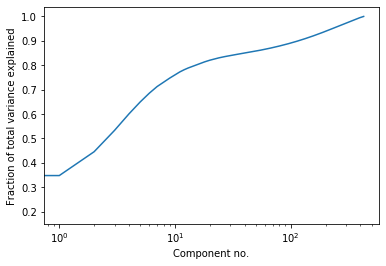

In [135]:
plt.semilogx(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Fraction of total variance explained')
plt.xlabel('Component no.')

The first N components explain this much of the total variance.

In [11]:
N = 12
print('{:.1f} percent'.format(100 * pca.explained_variance_ratio_[:N].sum()))

77.3 percent


Text(0, 0.5, 'Component number')

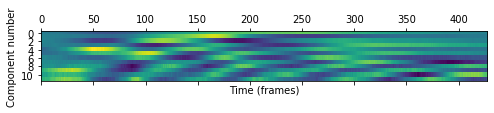

In [12]:
plt.figure(figsize=(8, 4))

ax = plt.subplot(111)
ax.matshow(pca.components_[:N, :], aspect=4)
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Component number')

Text(0, 0.5, 'Fluorescence (AU)')

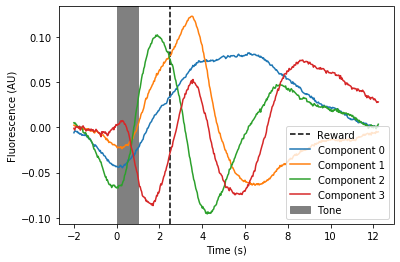

In [13]:
plt.axvspan(0, 1, color='gray', label='Tone')
plt.axvline(2.5, color='k', ls='--', label='Reward')

for i in range(4):
    plt.plot(grand_fluo.time - 2.0, pca.components_[i, :], label='Component {}'.format(i))
    
plt.legend(loc='lower right')
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (AU)')

## Denoising

Reconstruct fluorescence signals using only the top few components.

In [14]:
reconstructed = np.dot(transformed[:, :N], pca.components_[:N, :])

Compare a few randomly-selected reconstructions.

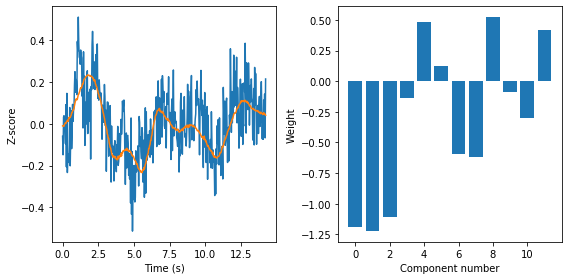

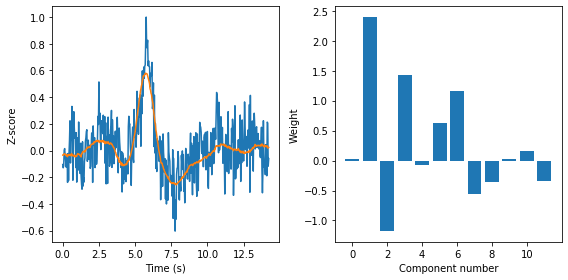

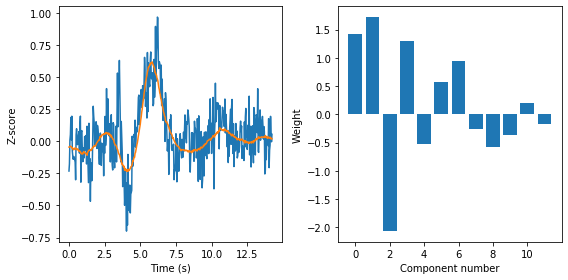

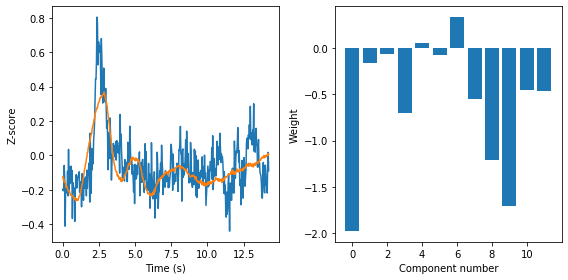

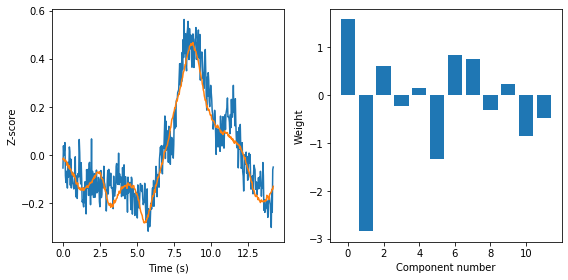

In [15]:
for i in np.random.choice(np.arange(0, grand_fluo.fluo.shape[0]), size=5, replace=False):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(121)
    plt.plot(grand_fluo.time, grand_fluo.fluo[i, :], label='Original')
    plt.plot(grand_fluo.time, reconstructed[i, :], label='Reconstructed')
    plt.xlabel('Time (s)')
    plt.ylabel('Z-score')
    
    plt.subplot(122)
    plt.bar(np.arange(0, N), transformed[i, :N])
    plt.ylabel('Weight')
    plt.xlabel('Component number')
    
    plt.tight_layout()
    plt.show()

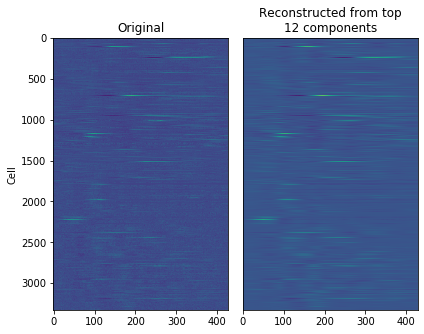

In [16]:
plt.figure(figsize=(6, 8))

ax = plt.subplot(121)
ax.set_title('Original')
ax.imshow(grand_fluo.fluo, aspect=0.2)
ax.set_ylabel('Cell')

ax_reconstructed = plt.subplot(122)
ax_reconstructed.set_title('Reconstructed from top\n{} components'.format(N))
ax_reconstructed.imshow(reconstructed, aspect=0.2)
ax_reconstructed.set_yticks([])

plt.tight_layout()

plt.show()

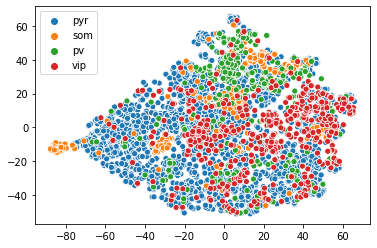

In [17]:
tsne_projection = TSNE(perplexity=30, init='pca', random_state=42).fit_transform(reconstructed)
sns.scatterplot(tsne_projection[:, 0], tsne_projection[:, 1], grand_fluo.cell_type)

# Representation of task structure

...using top components

The top few activity components explored above explain a large majority of Z-scored fluorescence. Next, we want to know how these components can capture trial structure.

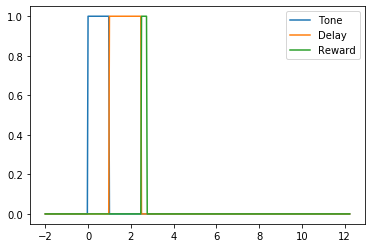

In [18]:
time_from_trial_start = (grand_fluo.time - 2.0)
tone = (time_from_trial_start >= 0.) & (time_from_trial_start < 1.)
delay = (time_from_trial_start >= 1.) & (time_from_trial_start < 2.5)
reward = (time_from_trial_start >= 2.5) & (time_from_trial_start < 2.75)

These are the activity components we'll try to use to capture the trial structure.

In [19]:
top_components = pca.components_[:N, :].T

In [20]:
def ols(X, y):
    # TODO add intercept
    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y - y.mean())
    coeffs = np.linalg.solve(XTX, XTy)
    return coeffs

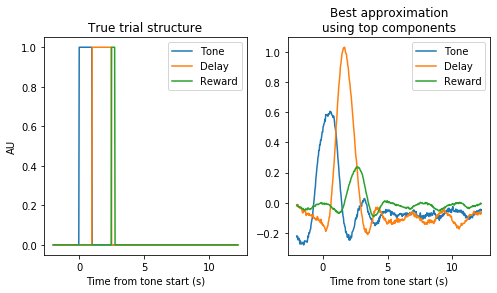

In [66]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.title('True trial structure')
plt.plot(time_from_trial_start, tone, label='Tone')
plt.plot(time_from_trial_start, delay, label='Delay')
plt.plot(time_from_trial_start, reward, label='Reward')
plt.ylabel('AU')
plt.xlabel('Time from tone start (s)')
plt.legend()

plt.subplot(122)
plt.title('Best approximation\nusing top components')
plt.plot(time_from_trial_start, np.dot(top_components, ols(top_components, tone)), label='Tone')
plt.plot(time_from_trial_start, np.dot(top_components, ols(top_components, delay)), label='Delay')
plt.plot(time_from_trial_start, np.dot(top_components, ols(top_components, reward)), label='Reward')
plt.xlabel('Time from tone start (s)')
plt.legend()

plt.show()

## How close does each cell type come to the best case?

In other words, how similar is the activity of each cell to the activity that most accurately reflects a task variable *within principal component space*.

In [67]:
def cos_similarity(a, b):
    assert np.ndim(a) == 1
    assert np.ndim(b) == 1
    assert len(a) == len(b)
    
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [76]:
def plot_similarities_by_celltype(similarities, cell_types):
    similarities = np.asarray(similarities)
    cell_types = np.asarray(cell_types)
    assert similarities.ndim == 1
    assert cell_types.ndim == 1
    assert len(similarities) == len(cell_types)
    
    plt.figure(figsize=(8, 4))

    ax_hist = plt.subplot(121)
    plt.xlim(-1, 1)
    plt.yticks([])
    plt.xticks([-1, -0.5, 0, 0.5, 1])
    plt.xlabel('Cosine similarity')

    ax_kde = plt.subplot(122)
    plt.xlim(-1, 1)
    plt.xticks([-1, -0.5, 0, 0.5, 1])
    plt.yticks([])
    plt.xlabel('Cosine similarity')

    bins = np.linspace(-1, 1, 30)
    ax_hist.hist(similarities, bins=bins, density=True, label='All cells', color='gray')
    sns.kdeplot(similarities, label='All cells', color='gray', shade=True, ax=ax_kde)

    for cell_type in cond.CellType:
        ax_hist.hist(
            similarities[cell_types == str(cell_type)],
            bins=bins,
            density=True,
            lw=2,
            label=str(cell_type), 
            histtype='step'
        )

        sns.kdeplot(
            similarities[cell_types == str(cell_type)],
            label=str(cell_type)
        )

    ax_hist.legend()
    ax_kde.legend()

    plt.tight_layout()
    plt.show()

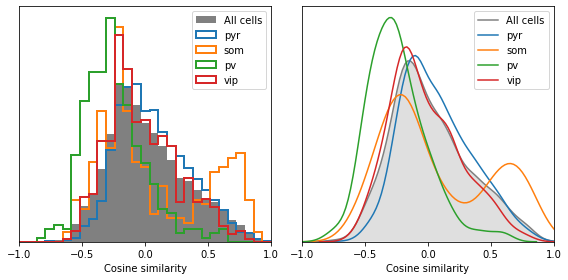

In [77]:
coeffs = ols(top_components, tone)
tone_similarities = np.array([cos_similarity(transformed[i, :N], coeffs) for i in range(transformed.shape[0])])
plot_similarities_by_celltype(tone_similarities, grand_fluo.cell_type)

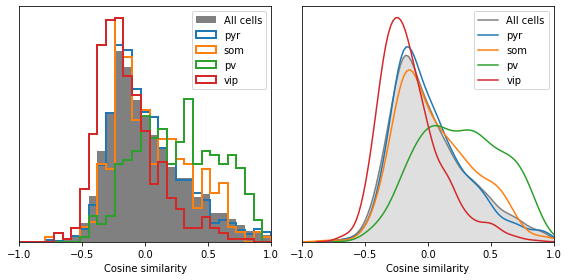

In [78]:
coeffs = ols(top_components, delay)
delay_similarities = np.array([cos_similarity(transformed[i, :N], coeffs) for i in range(transformed.shape[0])])
plot_similarities_by_celltype(delay_similarities, grand_fluo.cell_type)

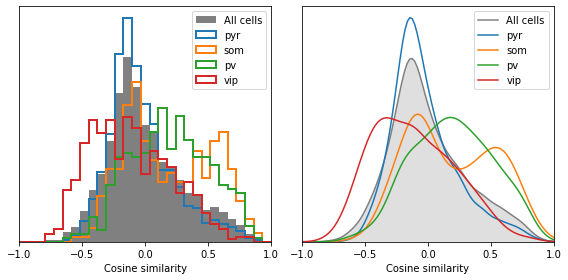

In [79]:
coeffs = ols(top_components, reward)
reward_similarities = np.array([cos_similarity(transformed[i, :N], coeffs) for i in range(transformed.shape[0])])
plot_similarities_by_celltype(reward_similarities, grand_fluo.cell_type)

### Are the SOM neurons that encode the tone/reward the new ones?

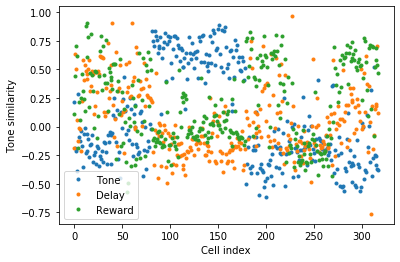

In [88]:
plt.plot(
    tone_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Tone'
)
plt.plot(
    delay_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Delay'
)
plt.plot(
    reward_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Reward'
)
plt.xlabel('Cell index')
plt.ylabel('Tone similarity')
plt.legend()

In [132]:
def plot_similarity_by_index(cell_type, smooth=False):
    for sim, label in zip(
        [tone_similarities, delay_similarities, reward_similarities], 
        ['Tone', 'Delay', 'Reward']
    ):
        sim_for_cell_type = sim[np.asarray(grand_fluo.cell_type) == str(cell_type)]
        x = np.arange(0, len(sim_for_cell_type))
        if smooth:
            spline = UnivariateSpline(x, sim_for_cell_type, s=3 * len(x) / 50)
            plt.plot(x, spline(x), '-', label=label)
        else:
            plt.plot(x, sim_for_cell_type, '.', label=label)

    plt.xlabel('Cell index')
    plt.ylabel('Tone similarity')
    plt.legend()

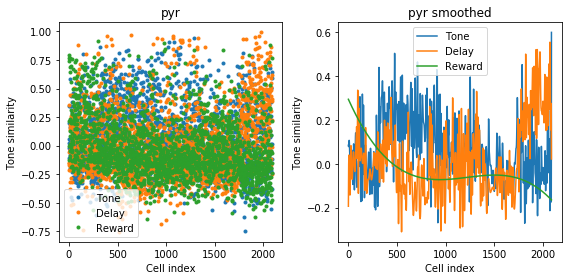

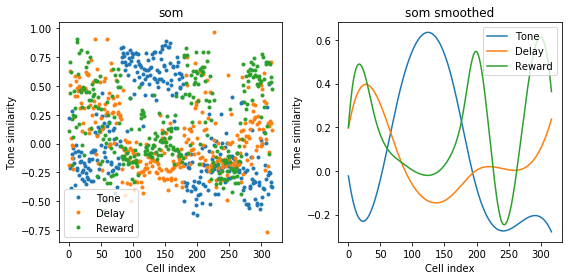

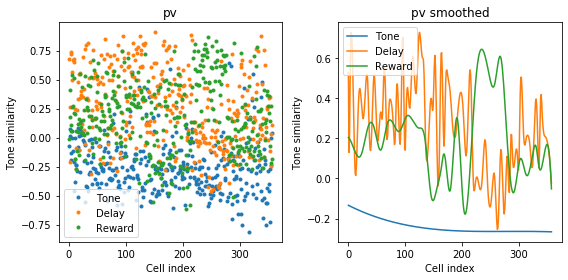

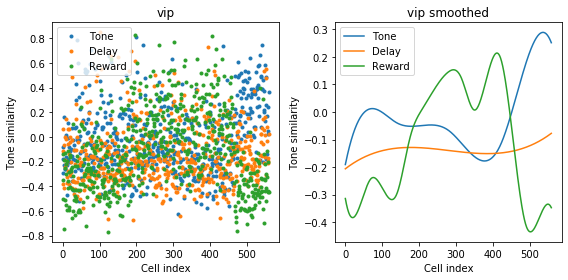

In [133]:
for cell_type in cond.CellType:
    plt.figure(figsize=(8, 4))
    
    plt.subplot(121)
    plt.title(str(cell_type))
    plot_similarity_by_index(cell_type)
    
    plt.subplot(122)
    plt.title(str(cell_type) + ' smoothed')
    plot_similarity_by_index(cell_type, True)
    
    plt.tight_layout()
    plt.show()

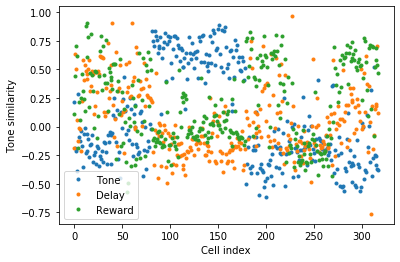

In [113]:
plt.plot(
    tone_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Tone'
)
plt.plot(
    delay_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Delay'
)
plt.plot(
    reward_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Reward'
)
plt.xlabel('Cell index')
plt.ylabel('Tone similarity')
plt.legend()